# Analysis Template
WIP new analysis template. Only to be used with most recent version of kinetics package as of 11/21/23.

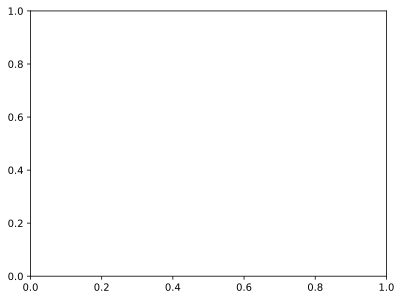

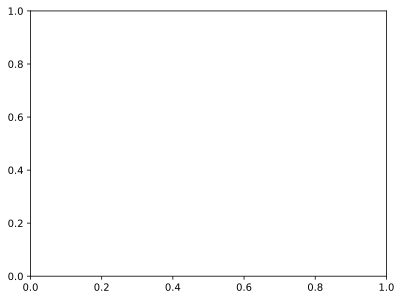

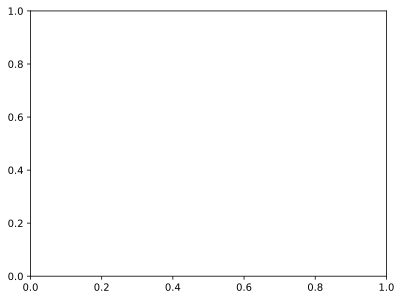

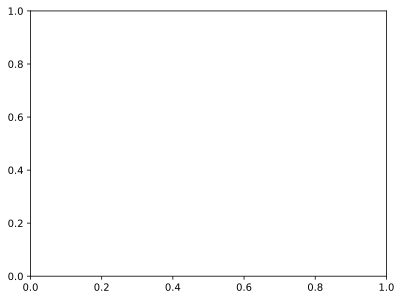

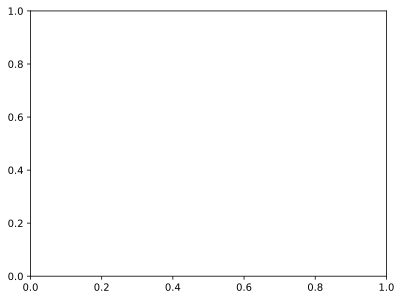

In [20]:
#MISSING PACKAGES: plotly, dash, pint

In [21]:
#enables autoreloding of modules
%load_ext autoreload
%autoreload 2

from copy import deepcopy
from pathlib import Path

import skimage
import math
import numpy as np
import pandas as pd
import scipy.stats
from pprint import pprint
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

from pathlib import Path 
from htbam_db_api.htbam_db_api import HTBAM_Experiment
from htbam_db_api.htbam_db_api import LocalHtbamDBAPI

#Import Kinetics Package for line fitting:
import kinetics
from kinetics.chip import analysis, visualization

import pint

#Configuration settings for pandas and seaborn
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.2f}'.format)
#sns.set(style='ticks', context='paper', font_scale=1.2, rc={"lines.linewidth": 1.2})

#enable inline plotting of matplotlib figures
%matplotlib inline

#set the figure format to SVG
%config InlineBackend.figure_format = 'svg'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
### Define our UNITS:
ureg = pint.UnitRegistry()
ureg.define('RFU = [luminosity]')

### SLOPE OF THE STANDARD CURVE
EGFP_SLOPE = 91900.03 * ureg('RFU/nM')def assay_data_to_array(db_obj, run_name):
    '''This function takes as input an HTBAM Database object.
    For each kinetics run, we have 
    It returns 3 numpy arrays:
    chamber_ids: an array of the chamber ids (in the format '1,1' ... '32,56')
        shape: (n_chambers,)
    luminance_data: an array of the luminance data for each chamber
        shape: (n_time_points, n_chambers, n_assays)
    conc_data: an array of the concentration data for each chamber.
        shape: (n_assays,)
    time_data: an array of the time data for each time point.
        shape: (n_time_points, n_assays)
    '''
    
    chamber_idxs = np.array(list(db_obj._json_dict['chamber_metadata'].keys()))
    luminance_data = None
    time_data = None
    conc_data = np.array([])

    #Each assay may have recorded a different # of time points.
    #First, we'll just check what the max # of time points is:
    max_time_points = 0
    for assay in db_obj._json_dict["runs"][run_name]['assays'].keys():
        current_assay_time_points = len(np.array(db_obj._json_dict["runs"][run_name]['assays'][assay]['time_s']))
        if current_assay_time_points > max_time_points:
            max_time_points = current_assay_time_points

    for assay in db_obj._json_dict["runs"][run_name]['assays'].keys():
        
        #to make things easier later, we'll be sorting the datapoints by time value.
        #Get time data:
        #collect from DB
        current_time_array = np.array(db_obj._json_dict["runs"][run_name]['assays'][assay]['time_s'])
        current_time_array = current_time_array.astype(float) #so we can pad with NaNs
        #pad the array with NaNs if there are fewer time points than the max
        current_time_array = np.pad(current_time_array, (0, max_time_points - len(current_time_array)), 'constant', constant_values=np.nan)
        #sort, and capture sorting idxs:
        sorting_idxs = np.argsort(current_time_array)
        current_time_array = current_time_array[sorting_idxs]
        current_time_array = np.expand_dims(current_time_array, axis=1)
        #add to our dataset
        if time_data is None:
            time_data = current_time_array
        else:
            time_data = np.concatenate([time_data, current_time_array], axis=1)

        #Get luminance data:
        current_luminance_array = None
        for chamber_idx in chamber_idxs:
            #collect from DB
            current_chamber_array = np.array(db_obj._json_dict["runs"][run_name]['assays'][assay]['chambers'][chamber_idx]['sum_chamber'])
            #set type to float:
            current_chamber_array = current_chamber_array.astype(float)
            #pad the array with NaNs if there are fewer time points than the max
            current_chamber_array = np.pad(current_chamber_array, (0, max_time_points - len(current_chamber_array)), 'constant', constant_values=np.nan)
            #sort by time:
            current_chamber_array = current_chamber_array[sorting_idxs]
            #add a dimension at the end:
            current_chamber_array = np.expand_dims(current_chamber_array, axis=1)

            if current_luminance_array is None:
                current_luminance_array = current_chamber_array
            else:
                current_luminance_array = np.concatenate([current_luminance_array, current_chamber_array], axis=1)
        #add a dimension at the end:
        current_luminance_array = np.expand_dims(current_luminance_array, axis=2)
        #add to our dataset
        if luminance_data is None:
            luminance_data = current_luminance_array
        else:
            luminance_data = np.concatenate([luminance_data, current_luminance_array], axis=2)
        
        #Get concentration data:
        #collect from DB
        current_conc = db_obj._json_dict["runs"][run_name]['assays'][assay]['conc']
        conc_data = np.append(conc_data, current_conc)

    #sort once more, by conc_data:
    sorting_idxs = np.argsort(conc_data)
    conc_data = conc_data[sorting_idxs]

    #sort luminance data by conc_data:
    luminance_data = luminance_data[:,:,sorting_idxs]
    
    return chamber_idxs, luminance_data, conc_data, time_data



In [4]:
### Plot a chip using a given variable, with subplots:

def plot_chip(plotting_var, chamber_names, graphing_function=None, title=None):
    ''' This function creates a Dash visualization of a chip, based on a certain Run (run_name)
        Inputs:
            plotting_var: a dictionary mapping chamber_id to the variable to be plotted for that chamber
            chamber_names: a dictionary mapping chamber_id to the name of the sample in the chamber (e.g. '1,1': ecADK_XYZ')
            graphing_function: a function that takes in a single chamber_id (e.g. '1,1') and matplotlib axis and returns the axis object after plotting.
            title: a string to be used as the title of the plot
        TODO: make all the variables stored in Dash properly...
    '''
    from dash import Dash, dcc, html, Input, Output, no_update
    import plotly.graph_objs as go
    import base64
    import tempfile

    # Make the image array
    #NB: eventually, store width/height in DB and reference!
    img_array = np.zeros([56,32])

    for chamber_id, value in plotting_var.items():
        x = int(chamber_id.split(',')[0])
        y = int(chamber_id.split(',')[1])
        img_array[y-1,x-1] = value 
    
    #generate title
    if title is None:
        title = ''
    
    #Create the figure
    layout = go.Layout()
    fig = go.Figure(layout=layout, data=go.Heatmap(z=img_array, colorscale='Viridis'))
    #center title in fig
    fig.update_layout(title=title,
                        title_x=0.5, 
                        yaxis=dict(scaleanchor="x", scaleratio=1, autorange='reversed'), 
                        xaxis=dict(scaleratio=1),
                        plot_bgcolor='rgba(0,0,0,0)',
                        width=600, height=600,
                        hovermode='x')
    fig.update_xaxes(showticklabels=False)
    fig.update_yaxes(showticklabels=False)

    #create dash app:
    app = Dash(__name__)
    app.layout = html.Div([
        dcc.Graph(id="graph", figure=fig, clear_on_unhover=True),
        dcc.Tooltip(id="graph-tooltip"),
    ])

    ### GRAPHING FUNCTION ON HOVER:
    if graphing_function is not None:
        @app.callback(
            Output("graph-tooltip", "show"),
            Output("graph-tooltip", "bbox"),
            Output("graph-tooltip", "children"),
            Input("graph", "hoverData"),
        )
        def display_hover(hoverData):
            if hoverData is None:
                return False, no_update, no_update
            # demo only shows the first point, but other points may also be available
            pt = hoverData["points"][0]
            chamber_id = str(pt['x']+1) + ',' + str(pt['y']+1)
            bbox = pt["bbox"]
            chamber_name = chamber_names[chamber_id]
            #get the data for the point:
            fig, ax = plt.subplots()
            ax = graphing_function(chamber_id, ax)
            #reduce whitespace on margins of graph:
            fig.subplots_adjust(left=0.2, bottom=0.1, right=0.9, top=0.9, wspace=0, hspace=0)
            #save the figure as a temp file:
            tempfile_name = tempfile.NamedTemporaryFile().name+'.png'
            plt.savefig(tempfile_name)
            plt.close()
            # #read in temp file as base64 encoded string:
            with open(tempfile_name, "rb") as image_file:
                img_src = "data:image/png;base64," + str(base64.b64encode(image_file.read()).decode("utf-8"))
            children = [
                html.Div(children=[
                    #no space after header:
                    html.H3('{},{}:  {}'.format(pt['x'], pt['y'], chamber_name), style={"color": 'black', "fontFamily":"Arial", "textAlign": "center", "marginBottom": "0px"}),
                    #add the image with reduced whitespace:
                    html.Img(src=img_src, style={"width": "90%"}),
                ],
                style={'width': '400px', 'white-space': 'none'})
            ]

            return True, bbox, children

    app.run_server()

## 1. Connect DB Api

In [23]:
#TODO: add proper file path parsing

root = '../local_test_data/garrison/'
root = Path(root)
db = HTBAM_Experiment('test_exp.HTBAM', new=True, units_registry=ureg)
print(db.get(''))

#load standards, kinetics, and button quant:
db.load_standard_data_from_file(
    standard_curve_data_path= root/'d2_5_StandardSeries_Analysis.csv.bz2', 
    standard_name="NADPH std curve", 
    standard_type="NADPH", 
    standard_units="uM",)
db.load_kinetics_data_from_file(
    kinetic_data_path= root/'d2_TitrationSeries_Analysis.csv.bz2', 
    kinetic_name="NADPH kinetics curve", 
    kinetic_type="NADPH", 
    kinetic_units="uM")
db.load_button_quant_data_from_file(root / 'd2_TitrationSeries_Analysis.csv.bz2')
#from htbam_analysis.htbam_db_api import LocalHtbamDBAPI

root = '../local_test_data/'
db_conn = LocalHtbamDBAPI(standard_curve_data_path= root + 'd1_2_StandardSeries_Analysis.csv.bz2', standard_name="NADPH std curve", standard_type="NADPH", standard_units="uM",
                         kinetic_data_path= root+ 'd1_TitrationSeries_Analysis.csv', kinetic_name="ADP kinetics curve", kinetic_type="ADP", kinetic_units="uM")

### TODO: Still want the following data in the database:
# date (and time?) collected
# operator name
# Add additional descriptors
# substrate_name
# setup(?) and device_num
# width/height


/home/nfreitas/workspace/pinney/htbam_db_api/src/htbam_db_api/htbam_db_api.py:45: DtypeWarning: Columns (10,26) have mixed types. Specify dtype option on import or set low_memory=False.
  self._kinetic_data = pd.read_csv(kinetic_data_path)


{'file_version': '0.0.1', 'chamber_metadata': {}, 'button_quant': {}, 'runs': {}}


#### Format of DB:
Useful? Or remove?
DB
- **chamber_metadata**
    - '1,1'
        - 'id'                  'organism_ADK'
        - 'radius_chamber'      35.0
        - 'x_center_chamber'    31.0
        - 'y_center_chamber'    43.0
        - 'xslice'              '(6758, 6805)'
        - 'yslice'              '(6704, 6804)'
    - ...
    - '32,56' ...
- **runs**
    - 'standard_0'
        - 'name'            'NAPDH_std_curve'
        - 'type'            'NAPDH'
        - 'conc_unit'       'uM'
        - 'assays':
            - 0:
                - 'conc'
                - 'time_s'
                - 'chambers'
                    - '1,1'
                    - ...
                    - '32,56' ...
            - ...
            - 6: ...
        - 'analyses':
            - 'linear_regression':
                - 'chambers':
                    - '1,1':
                        - slope:
                        - intercept:
                        - r_value:
                        - p_value: 
                        - std_err:
                    - ...
                    - '32,56'...


## 2. Standards

For each chamber, we've taken values at a set of concentrations. We need to perform a linear regression __for each chamber__ to relate the luminance of each chamber to its substrate concentration.

In our hierarchical data structure, we will store this linear regression as an analysis under the standard curve experiment. It is stored under:

```db_conn._json_dict['runs']['standard_0']['analyses']['linear_regression']```

And it stores the data:
```
{'chambers':  {'1,1': 
                     {'intercept': ...,
                      'p_value': ...,
                      'r2': ...,
                      'r_value': ...,
                      'slope': ...,
                      'std_err': ...,
                     }
               '1,2': {'intercept': ...}
              }
}
```


In [24]:
#let's automatigically generate the standard curve by doing a linear regression:
kinetics.chip.analysis.new_analysis(db, 'standard_0', 'linear_regression', 'linear_regression')

In [25]:
db.get('runs/standard_0/analyses/linear_regression')

{'chambers': {'1,1': {'slope': {'values': 22733.577962000814,
    'unit': 'RFU / micromolar',
    'is_quantity': True},
   'intercept': {'values': 43975.0999340429,
    'unit': 'RFU',
    'is_quantity': True},
   'r_value': {'values': 0.9998427526217066,
    'unit': 'dimensionless',
    'is_quantity': True},
   'r2': {'values': 0.9996855299701513,
    'unit': 'dimensionless',
    'is_quantity': True},
   'p_value': {'values': 5.954918030206768e-10,
    'unit': 'dimensionless',
    'is_quantity': True},
   'std_err': {'values': 180.31867981904105,
    'unit': 'RFU',
    'is_quantity': True}},
  '1,2': {'slope': {'values': 23678.734586242845,
    'unit': 'RFU / micromolar',
    'is_quantity': True},
   'intercept': {'values': 36383.9117678348,
    'unit': 'RFU',
    'is_quantity': True},
   'r_value': {'values': 0.9998331684188061,
    'unit': 'dimensionless',
    'is_quantity': True},
   'r2': {'values': 0.9996663646703887,
    'unit': 'dimensionless',
    'is_quantity': True},
   'p_va

### Sanity check:
Now, let's sanity check by plotting. We can use the ```plot_chip()``` function to show a chip where each chamber is colored by variable (like luminance). We can also make subplots on hover.

In [26]:
from kinetics.chip import visualization 
kinetics.chip.visualization.plot(db, 
                                 run_name=      'standard_0', 
                                 analysis_name= 'linear_regression', 
                                 plotting_var=  'r2', 
                                 title=         'Standard Curve', 
                                 hover_data=    ['conc', 'sum_chamber'])

/home/nfreitas/miniconda3/envs/htbam_analysis/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:201: UnitStrippedWarning:

The unit of the quantity is stripped when downcasting to ndarray.

/home/nfreitas/miniconda3/envs/htbam_analysis/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:129: UnitStrippedWarning:

The unit of the quantity is stripped when downcasting to ndarray.



## 7. Fit initial rates from processed kinetic data

For this next part, we'll be generating the predicted product concentration for each well, for each time, and for each substrate concentration. That's a 3D array.

To do this, we divide our luminance value (in RFUs) by the slope of the chamber's standard curve (RFU/conc). Here, we ignore the standard curve intercept.

In [27]:
chamber_coords, luminance_data, conc_data, time_data = db.get_run_data('kinetics_0')
print('Luminance data shape:', luminance_data.shape) #(time x wells x assays)


Luminance data shape: (20, 1792, 11)


Each well contains time_series data. We have 32*56 wells (1792), and then N assays with different concentrations.
So we have a np array with dimensions (time x wells x assays)
For a standard, this will be (1, 1792, # concentrations)
For a kinetics run, this will be (~20, 1792, # concentrations)

In [28]:
#make temporary copy of data:
chamber_dict = db.get(f'runs/standard_0/analyses/linear_regression/chambers/')
chamber_dict = db._make_quantities_from_serialized_dict(chamber_dict)

#concatenate all the slope quantities:
slope_quantities = [chamber_dict[i]['slope'] for i in chamber_dict.keys()]
# Assuming `slope_quantities` is the list of quantities
slope_array = np.array([q.magnitude for q in slope_quantities]) * slope_quantities[0].units
print('Slope quantities:', slope_array)



Slope quantities: [22733.577962000814 23678.734586242845 25638.041855449883 ... 24419.221985574775 24819.851263760345 22012.116355652008] RFU / micromolar


In [29]:
product_concentration = luminance_data / slope_array[np.newaxis, :, np.newaxis]
print('Product concentration shape:', product_concentration.shape)

Product concentration shape: (20, 1792, 11)


In [30]:
button_quant_no_background = np.array([])
button_quant_unit = None
chamber_dict = db.get(f'button_quant/')
chamber_dict = db._make_quantities_from_serialized_dict(chamber_dict)
for chamber_coord in chamber_coords:
    button_quant_no_background = np.append(button_quant_no_background, chamber_dict[chamber_coord]['summed_button_BGsub_Button_Quant'].magnitude)
    if button_quant_unit is None:
        button_quant_unit = chamber_dict[chamber_coord]['summed_button_BGsub_Button_Quant'].units
button_quant_no_background = button_quant_no_background * button_quant_unit

In [31]:
#what's the enzyme concentration in each well?
enzyme_concentration = button_quant_no_background / EGFP_SLOPE

In [32]:
enzyme_concentration.shape

(1792,)

In [33]:
#we should probably be storing these in the DB under a standard_0 analysis?

In [34]:
# #make numpy array of all button_quants with[ subtracted backgrounds:
# button_quant_no_background = [] #we will soon turn this into a numpy array
# for chamber_idx in chamber_idxs:
#     next_button_quant = db_conn._json_dict['button_quant'][chamber_idx]['summed_button_BGsub_Button_Quant']
#     button_quant_no_background.append(next_button_quant)
# button_quant_no_background = np.array(button_quant_no_background)

# # use eGFP standard curve to convert between button quant and eGFP concentration
# enzyme_concentration = button_quant_no_background / EGFP_SLOPE    #in units of EGFP_SLOPE_CONC_UNITS
# print('Enzyme concentration shape:', enzyme_concentration.shape)


### Fit initial rates

In [35]:
###TODO:
# 1) ~~I think addings nans kills the line fitting. Fix at some point. (in line fitting code, so we can keep nans?)~~
#    Fixed? Appears like it's working properly.
# 2) We're using the time values for the first chamber for all chambers. 
#    In practice, they're sometimes off by 1 second, which should not affect results much. Perhaps change in the future.
# 3) Kinetics fails without substrate_conc, even though it says it's optional. Also prints an ugly array which we should disable.

from kinetics import get_initial_slopes_quantities

#make an array of initial slopes for each chamber: should be (#chambers , #concentrations) = (1792 x 11)
initial_slopes = None
initial_slopes_R2 = None
for i, chamber_coord in enumerate(chamber_coords):

    #use the kinetics package to calculate the slopes for this chamber at each substrate concentration.
    current_chamber_slopes, current_chamber_R2 = kinetics.get_initial_slopes_quantities(time_data[:,0], product_concentration[:,i,:].T, substrate_concs=conc_data)

    #add a dimension at the end:
    current_chamber_slopes = np.expand_dims(current_chamber_slopes, axis=0)
    current_chamber_R2 = np.expand_dims(current_chamber_R2, axis=0)
    
    #add to our complete array:
    if initial_slopes is None:
        initial_slopes = current_chamber_slopes
        initial_slopes_R2 = current_chamber_R2
    else:
        initial_slopes = np.concatenate([initial_slopes, current_chamber_slopes], axis=0)
        initial_slopes_R2 = np.concatenate([initial_slopes_R2, current_chamber_R2], axis=0)

/home/nfreitas/workspace/pinney/kinetic_analysis/kinetics/functions.py:53: RuntimeWarning:

invalid value encountered in scalar divide

/home/nfreitas/workspace/pinney/kinetic_analysis/kinetics/functions.py:58: RuntimeWarning:

invalid value encountered in scalar divide

/home/nfreitas/workspace/pinney/kinetic_analysis/kinetics/functions.py:59: RuntimeWarning:

invalid value encountered in scalar divide

/home/nfreitas/workspace/pinney/kinetic_analysis/kinetics/functions.py:90: RuntimeWarning:

invalid value encountered in scalar divide

/home/nfreitas/workspace/pinney/kinetic_analysis/kinetics/functions.py:93: RuntimeWarning:

invalid value encountered in scalar divide

/home/nfreitas/workspace/pinney/kinetic_analysis/kinetics/functions.py:94: RuntimeWarning:

invalid value encountered in scalar divide



 This is likely due to scipy failing to fit a linear model to the data.
 This is likely due to scipy failing to fit a linear model to the data.
 This is likely due to scipy failing to fit a linear model to the data.
 This is likely due to scipy failing to fit a linear model to the data.
 This is likely due to scipy failing to fit a linear model to the data.
 This is likely due to scipy failing to fit a linear model to the data.
 This is likely due to scipy failing to fit a linear model to the data.
 This is likely due to scipy failing to fit a linear model to the data.
 This is likely due to scipy failing to fit a linear model to the data.
 This is likely due to scipy failing to fit a linear model to the data.
 This is likely due to scipy failing to fit a linear model to the data.
 This is likely due to scipy failing to fit a linear model to the data.
 This is likely due to scipy failing to fit a linear model to the data.
 This is likely due to scipy failing to fit a linear model to th

In [19]:
#Let's plot as before:
#plotting variable: We'll plot by luminance. We need a dictionary mapping chamber id (e.g. '1,1') to the value to be plotted (e.g. slope)
initial_rates_to_plot = {chamber_coords[i]: np.nanmax(initial_slopes[i,:]) for i in range(len(chamber_coords))}
#Plot the slopes of each chamber with 0 inhibitor: (the 0th value, since we sort concentration low to high)
zero_inhibitor_rates_to_plot = {chamber_idxs[i]: initial_slopes[i,0] for i in range(len(chamber_idxs))}

#chamber_names: Same as before.

#plotting function: We'll generate a subplot for each chamber, showing the raw data and the linear regression line.
# to do this, we make a function that takes in the chamber_id and the axis object, and returns the axis object after plotting. Do NOT plot.show() in this function.
def plot_chamber_initial_rates(chamber_id, ax):
    #N.B. Every so often, slope and line colors don't match up. Not sure why.
    #parameters: what amount of total time to plot? First 20%?
    time_to_plot = 0.2
    
    #convert from 'x,y' to integer index in the array:
    data_index = list(chamber_coords).index(chamber_id)

    x_data = time_data[:,0]
    y_data = product_concentration[:,data_index,:].T
    
    #plot only first X% of time:
    max_time = np.nanmax(x_data)
    time_to_plot = max_time*time_to_plot
    time_idxs_to_plot = x_data < time_to_plot
    x_data = x_data[time_idxs_to_plot]
    y_data = y_data[:, time_idxs_to_plot]
    
    #get slope from the analysis:
    current_chamber_slopes = initial_slopes[data_index,:]
    #calculate y-intercept by making sure it intersects first point:
    current_chamber_intercepts = y_data[:,0] - current_chamber_slopes*x_data[0] #note: not true y-intercept from linear regression
    
    for i in range(y_data.shape[0]): #over each concentration:
        ax.scatter(x_data, y_data[i,:])
        m = current_chamber_slopes[i]
        b = current_chamber_intercepts[i]
        if not (np.isnan(m) or np.isnan(b)):
            #return False, no_update, no_update
            ax.plot(x_data, m*np.array(x_data) + b)
    return ax


### PLOT THE CHIP: now, we plot
# kinetics.chip.visualization.plot(db, 
#                                  run_name=      'standard_0', 
#                                  analysis_name= 'linear_regression', 
#                                  plotting_var=  'r2', 
#                                  title=         'Standard Curve', 
#                                  hover_data=    ['conc', 'sum_chamber'])
#chamber_names: We'll provide the name of the sample in each chamber as well, in the same way:
chamber_names_dict = {chamber_idx: subdict['id'] for chamber_idx, subdict in db.get('chamber_metadata').items()}
kinetics.chip.visualization._plot_chip(initial_rates_to_plot, chamber_names_dict, graphing_function=plot_chamber_initial_rates, title='Kinetics: Initial Rates (Max)')plot_chip(zero_inhibitor_rates_to_plot, chamber_names_dict, graphing_function=plot_chamber_initial_rates, title='Kinetics: Initial Rates (Zero Inhibitor)')

/home/nfreitas/miniconda3/envs/htbam_analysis/lib/python3.10/site-packages/pint/facets/numpy/numpy_func.py:828: RuntimeWarning:

All-NaN slice encountered

/home/nfreitas/miniconda3/envs/htbam_analysis/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:201: UnitStrippedWarning:

The unit of the quantity is stripped when downcasting to ndarray.

/home/nfreitas/miniconda3/envs/htbam_analysis/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:129: UnitStrippedWarning:

The unit of the quantity is stripped when downcasting to ndarray.



[2023-12-12 11:10:49,117] ERROR in app: Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/nfreitas/miniconda3/envs/htbam_analysis/lib/python3.10/site-packages/flask/app.py", line 1455, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/nfreitas/miniconda3/envs/htbam_analysis/lib/python3.10/site-packages/flask/app.py", line 869, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/nfreitas/miniconda3/envs/htbam_analysis/lib/python3.10/site-packages/flask/app.py", line 867, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/nfreitas/miniconda3/envs/htbam_analysis/lib/python3.10/site-packages/flask/app.py", line 852, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
  File "/home/nfreitas/miniconda3/envs/htbam_analysis/lib/python3.10/site-packages/dash/dash.py", line 1310, in dispatch
    ctx.run(
  File "/home/nfreitas/miniconda3/envs/

## 8. Filter initial rates

#### Filters:
We will filter by masking our product_concentration array with NaN values

In [13]:
### Filter threshholds ###

#standard curve r^2 threshhold:
r2_threshold = 0.98

#enzyme expression threshhold:
expression_threshhold = 1.0
expression_threshhold_units = 'nM'

#initial rate fit R^2 threshhold:
intitial_rate_R2_threshhold = 0.8

#slope threshold for zero-inhibitor:
zero_inhibitor_slope_threshhold = 0.001

In [14]:
### Make filters ###

# STANDARD CURVE FILTER #
# overwrite all chambers (rows) with r^2 values below the threshold with NaNs:
filter_r2 = np.ones_like(initial_slopes)
r2_values = np.array([db_conn._json_dict['runs']['standard_0']['analyses']['linear_regression']['chambers'][chamber_idx]['r2'] for chamber_idx in chamber_idxs])
_count = 0
for i, chamber_idx in enumerate(chamber_idxs):
    if r2_values[i] < r2_threshold:
        _count +=1
        filter_r2[i, :] = np.nan
print('Pearson r^2 filter: {}/{} chambers pass'.format(len(chamber_idxs)-_count, len(chamber_idxs)))

# ENZYME EXPRESSION FILTER #
# overwrite all chambers (rows) with enzyme expression below the threshold with NaNs:
#Double check the expression units match the EGFP units:
assert expression_threshhold_units == EGFP_SLOPE_CONC_UNITS, 'Error, enzyme expression and EGFP standard curve units do not match!'
filter_enzyme_expression = np.ones_like(initial_slopes)
_count = 0
for i, chamber_idx in enumerate(chamber_idxs):
    if enzyme_concentration[i] < expression_threshhold:
        _count +=1
        filter_enzyme_expression[i,:] = np.nan
print('Enzyme expression filter: {}/{} chambers pass'.format(len(chamber_idxs)-_count, len(chamber_idxs)))

# ZERO-INHIBITOR SLOPE FILTER #
# overwrite all chambers (rows) where the initial slope is below the threshhold with NaNs:
filter_zero_inhibitor_rate = np.ones_like(initial_slopes)
_count = 0
for i, chamber_idx in enumerate(chamber_idxs):
    if initial_slopes[i,0] < zero_inhibitor_slope_threshhold:
        _count +=1
        filter_zero_inhibitor_rate[i,:] = np.nan
print('0 Inhibitor rate filter: {}/{} chambers pass'.format(len(chamber_idxs)-_count, len(chamber_idxs)))

# INITIAL RATE FIT FILTER #
# overwrite just the assays per chamber (single values) with initial rate fit R^2 values below the threshold with NaNs:
filter_initial_rate_R2 = np.ones_like(initial_slopes)
_count = 0
for i, chamber_idx in enumerate(chamber_idxs):
    _chamber_count = 0
    for j in range(len(conc_data)):
        if initial_slopes_R2[i,j] < intitial_rate_R2_threshhold:
            _chamber_count +=1
            filter_initial_rate_R2[i,j] = np.nan
    if len(conc_data) - _chamber_count < 10:
        _count +=1
print('Initial Rate R^2 filter: {}/{} chambers pass with 10 or more slopes.'.format(len(chamber_idxs)-_count, len(chamber_idxs)))

# POSITIVE INITIAL SLOPE FILTER #
# overwrite just the assays per chamber (single values) with initial slopes below zero with NaNs:
filter_positive_initial_slope = np.ones_like(initial_slopes)
_count = 0
for i, chamber_idx in enumerate(chamber_idxs):
    _chamber_count = 0
    for j in range(len(conc_data)):
        if initial_slopes[i,j] < 0:
            _chamber_count +=1
            filter_positive_initial_slope[i,j] = np.nan
    if len(conc_data) - _chamber_count < 10:
        _count +=1
print('Positive Initial Slope filter: {}/{} chambers pass with 10 or more slopes.'.format(len(chamber_idxs)-_count, len(chamber_idxs)))


### manually flagged wells ###
#TODO: implement


Pearson r^2 filter: 1792/1792 chambers pass
Enzyme expression filter: 1521/1792 chambers pass
0 Inhibitor rate filter: 1425/1792 chambers pass
Initial Rate R^2 filter: 1792/1792 chambers pass with 10 or more slopes.
Positive Initial Slope filter: 1741/1792 chambers pass with 10 or more slopes.


In [15]:
### Filter data ###
#apply filters:
filters = [filter_r2, filter_enzyme_expression, filter_initial_rate_R2, filter_positive_initial_slope, filter_zero_inhibitor_rate]

filtered_initial_slopes = deepcopy(initial_slopes)
for filter in filters: filtered_initial_slopes *= filter

#then, filter our enzyme concentration:
enzyme_concentration_filtered = enzyme_concentration * filter_enzyme_expression[:,0]

In [16]:
# chamber_idxs, luminance_data, conc_data, time_data

#save filtered data to new analysis:
if 'analyses' not in db_conn._json_dict['runs']['kinetics_0'].keys():
    db_conn._json_dict['runs']['kinetics_0']['analyses'] = {}

#initialize the dictionary
db_conn._json_dict['runs']['kinetics_0']['analyses']['initial_slopes_filtered'] = {
        'filters': ['filter_r2', 'filter_enzyme_expression', 'filter_initial_rate_R2', 'filter_positive_initial_slope'],
        'filter_r2': r2_threshold,
        'filter_enzyme_expression': expression_threshhold,
        'filter_enzyme_expression_units': expression_threshhold_units,
        'filter_initial_rate_R2': intitial_rate_R2_threshhold,
        'filter_positive_initial_slope': True,
        'assays': {}} 

for i in range(len(conc_data)):
    db_conn._json_dict['runs']['kinetics_0']['analyses']['initial_slopes_filtered']['assays'][i] = {
        'substrate_conc': conc_data[i],
        'chambers': {}
    }
    for j, chamber_idx in enumerate(chamber_idxs):
        db_conn._json_dict['runs']['kinetics_0']['analyses']['initial_slopes_filtered']['assays'][i]['chambers'][chamber_idx] = {
            'slope': filtered_initial_slopes[j,i],
            'r2': initial_slopes_R2[j,i]
        }

In [17]:
###N.B.: May be some bug here, because some of the filtered-out chambers are still showing slopes.
# I think they should have all nans...?

#Let's plot as before:
#plotting variable: We'll plot by luminance. We need a dictionary mapping chamber id (e.g. '1,1') to the value to be plotted (e.g. slope)
filtered_initial_rates_to_plot = {chamber_idxs[i]: np.any(~np.isnan(filtered_initial_slopes[i,:])) for i in range(len(chamber_idxs))}

#chamber_names: Same as before.

#plotting function: We'll generate a subplot for each chamber, showing the raw data and the linear regression line.
# to do this, we make a function that takes in the chamber_id and the axis object, and returns the axis object after plotting. Do NOT plot.show() in this function.
def plot_chamber_filtered_initial_rates(chamber_id, ax):
    #N.B. Every so often, slope and line colors don't match up. Not sure why.
    #parameters: what amount of total time to plot? First 20%?
    time_to_plot = 0.2
    
    #convert from 'x,y' to integer index in the array:
    data_index = list(chamber_idxs).index(chamber_id)

    x_data = time_data[:,0]
    y_data = product_concentration[:,data_index,:].T
    
    #plot only first X% of time:
    max_time = np.nanmax(x_data)
    time_to_plot = max_time*time_to_plot
    time_idxs_to_plot = x_data < time_to_plot
    x_data = x_data[time_idxs_to_plot]
    y_data = y_data[:, time_idxs_to_plot]
    
    #get slope from the analysis:
    current_chamber_slopes = filtered_initial_slopes[data_index,:]
    #calculate y-intercept by making sure it intersects first point:
    current_chamber_intercepts = y_data[:,0] - current_chamber_slopes*x_data[0] #note: not true y-intercept from linear regression
    
    for i in range(y_data.shape[0]): #over each concentration:
        ax.scatter(x_data, y_data[i,:])
        m = current_chamber_slopes[i]
        b = current_chamber_intercepts[i]
        if not (np.isnan(m) or np.isnan(b)):
            #return False, no_update, no_update
            ax.plot(x_data, m*np.array(x_data) + b)
    return ax


### PLOT THE CHIP: now, we plot
plot_chip(filtered_initial_rates_to_plot, chamber_names_dict, graphing_function=plot_chamber_filtered_initial_rates, title='Kinetics: Filtered Initial Rates (Max)')
print('{}/1792 wells pass our filters.'.format( np.sum([x for x in filtered_initial_rates_to_plot.values()]) ) )

1188/1792 wells pass our filters.


## 9. Fit Inhibition Constant:

In [18]:
substrate_conc_unit = db_conn._json_dict['runs']['kinetics_0']['conc_unit']
if  substrate_conc_unit != EGFP_SLOPE_CONC_UNITS: print('Substrate concentration units do not match EGFP standard curve units! \n{} != {}'.format(substrate_conc_unit, EGFP_SLOPE_CONC_UNITS))

unit_converstion = 0.001 #convert FROM eGFP units TO substrate units (in this case, nM to uM)
enzyme_concentration_converted_units = enzyme_concentration_filtered * unit_converstion

#Double check!
print('Conversion:')
print('{} {} = {} {}  ?'.format(enzyme_concentration[0], EGFP_SLOPE_CONC_UNITS, enzyme_concentration_converted_units[0], substrate_conc_unit))


Substrate concentration units do not match EGFP standard curve units! 
uM != nM
Conversion:
0.022927087183758264 nM = nan uM  ?


In [19]:
#Here, we calculate the Michaelis-Menten parameters for each chamber.

K_i_array = np.array([])
K_i_error_array = np.array([])

for i in range(len(chamber_idxs)):
    current_slopes = filtered_initial_slopes[i, :]

    if np.all(np.isnan(current_slopes)):
        print('Chamber {} has no slopes!'.format(chamber_idxs[i]))
        K_i_array = np.append(K_i_array, np.nan)
        K_i_error_array = np.append(K_i_error_array, np.nan)
        continue

    #get indices of non-nan values:
    non_nan_idxs = np.where(~np.isnan(current_slopes))[0]
    
    current_slopes = current_slopes[non_nan_idxs]
    current_concs = conc_data[non_nan_idxs]

    if len(current_slopes) < 3:
        print('Chamber {} has fewer than 3 slopes!'.format(chamber_idxs[i]))
        K_i_array = np.append(K_i_array, np.nan)
        K_i_error_array = np.append(K_i_error_array, np.nan)
        continue
    
    #kinetics.fit_and_plot_micheaelis_menten(current_slopes, current_slopes, current_concs, enzyme_concentration_converted_units[i], 'uM', 'MM for first chamber!')
    K_i, std_err = kinetics.fit_inhibition_constant(current_slopes, current_slopes, current_concs, enzyme_concentration_converted_units[i], 'uM', 'MM for first chamber!')
    K_i_array = np.append(K_i_array, K_i)
    K_i_error_array = np.append(K_i_error_array, std_err[0])

#in case we're not using Cheng-Prusoff:
K_i_array_corrected = K_i_array
K_i_error_array_corrected = K_i_error_array


Chamber 1,1 has no slopes!
Chamber 1,2 has no slopes!
Chamber 1,4 has no slopes!
Chamber 1,5 has no slopes!
Chamber 1,6 has fewer than 3 slopes!
Chamber 1,7 has fewer than 3 slopes!
Chamber 1,8 has no slopes!
Chamber 1,9 has no slopes!
Chamber 1,10 has no slopes!
Chamber 1,11 has no slopes!
Chamber 1,12 has no slopes!
Chamber 1,13 has no slopes!
Chamber 1,14 has no slopes!
Chamber 1,15 has no slopes!
Chamber 1,17 has fewer than 3 slopes!
Chamber 1,18 has no slopes!
Chamber 1,19 has no slopes!
Chamber 1,22 has no slopes!
Chamber 1,23 has fewer than 3 slopes!
Chamber 1,24 has no slopes!
Chamber 1,25 has no slopes!
Chamber 1,26 has no slopes!
Chamber 1,27 has no slopes!
Chamber 1,28 has no slopes!
Chamber 1,29 has no slopes!
Chamber 1,30 has no slopes!
Chamber 1,31 has no slopes!
Chamber 1,32 has no slopes!
Chamber 1,34 has no slopes!
Chamber 1,36 has no slopes!
Chamber 1,40 has no slopes!
Chamber 1,41 has no slopes!
Chamber 1,43 has no slopes!
Chamber 1,44 has no slopes!
Chamber 1,47 has

#### Optional: Correct with Cheng-Prusoff, using $K_M$.
To use this, the $K_M$ input CSV ('sample_KMs.csv') must have the following columns:
| Sample Name | K_M (uM) |
|-------------|----------|
| (string)  |  float | 
| $\vdots$  |  $\vdots$ | 


Additionally, please input the substrate_concentration for this assay (previously, we have been dealing with the inhibitor_concentration for fitting.)

In [20]:
import csv

assay_substrate_conc = 0 # uM

sample_KM_dict = {}
#get sample_names and KMs from csv:
with open('sample_KMs.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        sample_KM_dict[row['Sample Name']] = float(row['K_M (uM)'])

K_M_array = np.array([])
for chamber_idx in chamber_idxs:
    #get the sample name for this chamber:
    sample_name = chamber_names_dict[chamber_idx]
    if sample_name not in sample_KM_dict.keys():
        print('Sample {} not found in sample_KMs.csv!'.format(sample_name))
        K_M_array = np.append(K_M_array, np.nan)
        continue
    current_K_M = sample_KM_dict[sample_name]
    K_M_array = np.append(K_M_array, current_K_M)

#correct each K_i using cheng-prusoff:
K_i_array_corrected = kinetics.apply_cheng_prusoff(K_i_array, K_M_array, assay_substrate_conc, conc_units='uM')
K_i_error_array_corrected = kinetics.apply_cheng_prusoff(K_i_error_array, K_M_array, assay_substrate_conc, conc_units='uM')


Sample 1229 not found in sample_KMs.csv!
Sample 1248 not found in sample_KMs.csv!
Sample 1248 not found in sample_KMs.csv!
Sample 1252 not found in sample_KMs.csv!
Sample 1235 not found in sample_KMs.csv!
Sample 1268 not found in sample_KMs.csv!
Sample Buffer not found in sample_KMs.csv!
Sample 1125 not found in sample_KMs.csv!
Sample 1248 not found in sample_KMs.csv!
Sample 1274 not found in sample_KMs.csv!
Sample 1271 not found in sample_KMs.csv!
Sample 1274 not found in sample_KMs.csv!
Sample 1271 not found in sample_KMs.csv!
Sample 1231 not found in sample_KMs.csv!
Sample 1243 not found in sample_KMs.csv!
Sample 1271 not found in sample_KMs.csv!
Sample 1231 not found in sample_KMs.csv!
Sample 1244 not found in sample_KMs.csv!
Sample Buffer not found in sample_KMs.csv!
Sample 1252 not found in sample_KMs.csv!
Sample 1235 not found in sample_KMs.csv!
Sample 1244 not found in sample_KMs.csv!
Sample 1207 not found in sample_KMs.csv!
Sample 1273 not found in sample_KMs.csv!
Sample 1232 

In [21]:
# chamber_idxs, luminance_data, conc_data, time_data

#save filtered data to new analysis:
if 'analyses' not in db_conn._json_dict['runs']['kinetics_0'].keys():
    db_conn._json_dict['runs']['kinetics_0']['analyses'] = {}

#initialize the dictionary
db_conn._json_dict['runs']['kinetics_0']['analyses']['K_i_raw'] = {
        'chambers': {}} 

#TODO: currently, we're actually saving K_i/E. This is reflected in output but not in our internal names
# this will be fixed in the next refactor.
for i, chamber_idx in enumerate(chamber_idxs):
    db_conn._json_dict['runs']['kinetics_0']['analyses']['K_i_raw']['chambers'][chamber_idx] = {
        'K_i': K_i_array_corrected[i],
        'K_i_error': K_i_error_array_corrected[i],
    }

In [22]:
#Get chamber ids from metadata:
chamber_name_to_idx = {}
for chamber_idx, subdict in db_conn._json_dict['chamber_metadata'].items():
    name = subdict['id']
    if name not in chamber_name_to_idx.keys():
        chamber_name_to_idx[name] = [chamber_idx]
    else:
        chamber_name_to_idx[name].append(chamber_idx)

#get average number of replicates:
n_replicates = np.mean([len(x) for x in chamber_name_to_idx.values()])
print('Average number of replicates per sample: {}'.format(np.round(n_replicates, 1)))

Average number of replicates per sample: 27.2


In [23]:
z_score_threshhold_MM = 1.5
z_score_threshhold_expression = 1.5

In [24]:
#Get average k_cat, k_M, and v_max for each sample:
sample_names = np.array([])
sample_K_i = np.array([])
sample_K_i_error = np.array([])
sample_K_i_replicates = []

#Get z-scores for each well (used to filter in the next step!)
K_i_zscores = np.array([])
enzyme_concentration_zscores = np.array([])

#For each sample, 
for name, ids in chamber_name_to_idx.items():

    ### GATHER MM PARAMETERS OF REPLICATES FOR EACH SAMPLE: ###
    #get indices of idxs in chamber_idxs:
    idxs = [list(chamber_idxs).index(x) for x in ids]

    #get values for those indices:
    K_i = K_i_array_corrected[idxs]
    #keep track of which wells we exclude later:
    K_i_replicates = np.array(ids)

    #if any of these is all nans, just continue to avoid errors:
    if np.all(np.isnan(K_i)):
        print('No values from sample {}, all pre-filtered.'.format(name))
        continue

    ### FILTER OUT OUTLIERS: ###
    #calculate z-score for each value:
    K_i_zscore = (K_i - np.nanmean(K_i))/np.nanstd(K_i)

    #also, get z-score of enzyme expression for each well:
    enzyme_concentration_zscore = (enzyme_concentration_converted_units[idxs] - np.nanmean(enzyme_concentration_converted_units[idxs]))/np.nanstd(enzyme_concentration_converted_units[idxs]) #in units of 'substrate_conc_unit' 

    #First, for enzyme expression outliers, set the value to NaN to be filtered in the final step:
    K_i[np.abs(enzyme_concentration_zscore) > z_score_threshhold_expression] = np.nan

    #filter out values with z-score > threshhold:
    K_i = K_i[np.abs(K_i_zscore) < z_score_threshhold_MM]

    #do the same for the replicates ids:
    K_i_replicates = K_i_replicates[np.abs(K_i_zscore) < z_score_threshhold_MM]

    #remove nan values from all (nan values are due to both no experimental data, and z-score filtering)
    K_i_replicates = K_i_replicates[~np.isnan(K_i)]
    K_i = K_i[~np.isnan(K_i)]

    if len(K_i) < 3:
        print('Not enough replicates for sample {}. Skipping.'.format(name))
        continue
    
    #get average values:
    sample_names = np.append(sample_names, name)
    sample_K_i = np.append(sample_K_i, np.mean(K_i))
    sample_K_i_error = np.append(sample_K_i_error,np.std(K_i))
    
    #keep track of replicates:
    sample_K_i_replicates.append(K_i_replicates)



No values from sample 1229, all pre-filtered.
No values from sample 1248, all pre-filtered.
No values from sample 1252, all pre-filtered.
No values from sample 1235, all pre-filtered.


No values from sample 1268, all pre-filtered.
No values from sample Buffer, all pre-filtered.
No values from sample 1125, all pre-filtered.
No values from sample 1274, all pre-filtered.
No values from sample 1271, all pre-filtered.
No values from sample 1231, all pre-filtered.
No values from sample 1243, all pre-filtered.
No values from sample 1244, all pre-filtered.
No values from sample 1207, all pre-filtered.
No values from sample 1273, all pre-filtered.
No values from sample 1232, all pre-filtered.
No values from sample 1143, all pre-filtered.
No values from sample 1209, all pre-filtered.
No values from sample 1233, all pre-filtered.
No values from sample 1225, all pre-filtered.


In [25]:
#save filtered data to new analysis:
if 'analyses' not in db_conn._json_dict['runs']['kinetics_0'].keys():
    db_conn._json_dict['runs']['kinetics_0']['analyses'] = {}

#initialize the dictionary
db_conn._json_dict['runs']['kinetics_0']['analyses']['K_i_filtered'] = {
        'samples': {}} 

for i, sample_name in enumerate(sample_names):
    db_conn._json_dict['runs']['kinetics_0']['analyses']['K_i_filtered']['samples'][sample_name] = {
        'K_i': sample_K_i[i],
        'K_i_error': sample_K_i_error[i],
        'K_i_replicates': sample_K_i_replicates[i],
    }

In [27]:
#visualize:
#plotting variable: We'll plot by K_M. We need a dictionary mapping chamber id (e.g. '1,1') to the value to be plotted
#first, fill it with NaNs as a placeholder:
K_i_to_plot = {chamber_idx: np.nan for chamber_idx in chamber_idxs}
#then, fill in the values we have:
for i in range(len(sample_names)):
    for chamber_idx in chamber_name_to_idx[sample_names[i]]:
        K_i_to_plot[chamber_idx] = sample_K_i[i]

#chamber_names: We'll provide the name of the sample in each chamber as well, in the same way:
chamber_names_dict = {chamber_idx: subdict['id'] for chamber_idx, subdict in db_conn._json_dict['chamber_metadata'].items()}


#plotting function: We'll generate an MM subplot for each chamber.
def plot_chamber_K_i(chamber_id, ax):
    def inhibition_model(x, Ki, v_0):
        return v_0 / (1 + (x / Ki))
    
    #find the name of the chamber:
    chamber_name = chamber_names_dict[chamber_id]
    #first, find all chambers with this name:
    #if there's no data, just skip!
    if chamber_name not in db_conn._json_dict['runs']['kinetics_0']['analyses']['K_i_filtered']['samples']:
        return ax
    chamber_id_list = db_conn._json_dict['runs']['kinetics_0']['analyses']['K_i_filtered']['samples'][chamber_name]['K_i_replicates']

    #convert to array indices:
    chamber_id_list = [list(chamber_idxs).index(x) for x in chamber_id_list]

    #get the initial rates for each chamber:
    initial_slopes = filtered_initial_slopes[chamber_id_list,:]
    #divide by enzyme concentration:
    initial_slopes_on_E = initial_slopes / enzyme_concentration_converted_units[chamber_id_list, np.newaxis]
    #get average
    initial_slopes_on_E_avg = np.nanmean(initial_slopes_on_E, axis=0)
    #get error bars
    initial_slopes_on_E_std = np.nanstd(initial_slopes_on_E, axis=0)

    #get the substrate concentrations that match with each initial rate:
    substrate_concs = conc_data

    x_data = substrate_concs
    y_data = initial_slopes_on_E_avg

    data_index = list(chamber_idxs).index(chamber_id)
    current_chamber_slopes = filtered_initial_slopes[data_index,:]
    current_chamber_slopes_on_E = current_chamber_slopes / enzyme_concentration_converted_units[data_index]
    
    #make x,y labels:
    ax.set_xlabel('[I] ({})'.format(substrate_conc_unit))
    ax.set_ylabel('Ki/[E]')

    #plot with error bars:
    ax.errorbar(x_data, y_data, yerr=initial_slopes_on_E_std, fmt='o', label="all replicates")

    #get enzyme concentration:
    enzyme_conc = np.nanmean(enzyme_concentration_converted_units[chamber_id_list])

    #plot the fit:
    #get the Ki and v_0 from the database:
    Ki = K_i_to_plot[chamber_id] * enzyme_conc
    v_0 = y_data[0]
    
    #plot dotted line
    ax.plot(x_data, inhibition_model(x_data, Ki, v_0), '--', linewidth=2,  label="MM fit")

    #plot over everything else:
    ax.scatter(x_data, current_chamber_slopes_on_E, marker='o', color='red', s=50, zorder=10,  label="current chamber")
    
    ax.legend()
    
    return ax

### PLOT THE CHIP: now, we plot
plot_chip(K_i_to_plot, chamber_names_dict, graphing_function=plot_chamber_K_i, title='Filtered Ki')

## 10. Export to CSV in format people like

In [27]:
#Summary CSV, showing data for each SAMPLE:
output_csv_name = 'inhibition_summary_2'

import csv
with open(output_csv_name+'_short.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    #write header:
    writer.writerow(['id', 
                     'substrate_name', 
                     'assay_type', 
                     'replicates', 
                     'Ki_mean_filtered, '+substrate_conc_unit,
                     'Ki_mean_filtered/[E]', 
                     'Ki_stdev_filtered/[E]', 
                     'enzyme, '+substrate_conc_unit])
    #write data:
    for i, sample_name in enumerate(sample_names):
        #get the chamber indices for this sample:
        chamber_indices = np.where(np.isin(chamber_idxs, chamber_name_to_idx[sample_name]))[0]
        #get average enzyme conc:
        enzyme_conc = np.nanmean(enzyme_concentration_converted_units[chamber_indices])
        row = [sample_name,
               sample_name,
               db_conn._json_dict['runs']['kinetics_0']['type'], 
               len(sample_K_i_replicates[i]), 
               sample_K_i[i]*enzyme_conc,
               sample_K_i[i], 
               sample_K_i_error[i], 
               enzyme_conc,
               ]
        writer.writerow(row)

/tmp/ipykernel_12641/918585844.py:33: RuntimeWarning:

Mean of empty slice

/home/nfreitas/miniconda3/envs/htbam_analysis/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning:

Degrees of freedom <= 0 for slice.



In [30]:
#Full CSV, showing data for each CHAMBER:
import csv
output_csv_name = 'inhibition_2'

with open(output_csv_name+'.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    #write header:
    writer.writerow(['id', 
                     'x,y',
                     'substrate_name', 
                     'assay_type', 
                     'replicates', 
                     'Ki, '+substrate_conc_unit,
                     'Ki/[E]', 
                     'Ki_mean_filtered/[E]', 
                     'Ki_stdev_filtered/[E]', 
                     'enzyme, '+substrate_conc_unit,])
    #write data for each chamber:
    for i, chamber_idx in enumerate(chamber_idxs):
        sample_name = chamber_names_dict[chamber_idx]
        #get index in sample_names:
        if sample_name in sample_names:
            sample_idx = list(sample_names).index(sample_name)
            row = [chamber_names_dict[chamber_idx], #id
                    chamber_idx, #x,y
                    sample_name, #substrate_name
                    db_conn._json_dict['runs']['kinetics_0']['type'], #assay_type
                    len(sample_K_i_replicates[sample_idx]), #replicates
                    db_conn._json_dict['runs']['kinetics_0']['analyses']['K_i_raw']['chambers'][chamber_idx]['K_i']*enzyme_concentration_converted_units[i], #ki
                    db_conn._json_dict['runs']['kinetics_0']['analyses']['K_i_raw']['chambers'][chamber_idx]['K_i'], #ki/E
                    sample_K_i[sample_idx], #ki_mean_filtered/E
                    sample_K_i_error[sample_idx], #ki_stdev_filtered/E
                    enzyme_concentration_converted_units[i], #enzyme
                    ]
        else:
            row = [chamber_names_dict[chamber_idx], #id
                    chamber_idx, #x,y
                    sample_name, #substrate_name
                    db_conn._json_dict['runs']['kinetics_0']['type'], #assay_type
                    'NaN', #replicates
                    db_conn._json_dict['runs']['kinetics_0']['analyses']['K_i_raw']['chambers'][chamber_idx]['K_i']*enzyme_concentration_converted_units[i], #kcat
                    db_conn._json_dict['runs']['kinetics_0']['analyses']['K_i_raw']['chambers'][chamber_idx]['K_i'], #kcat
                    'NaN', #K_i_mean_filtered
                    'NaN', #K_i_stdev_filtered
                    enzyme_concentration_converted_units[i], #enzyme
            ]
        
        writer.writerow(row)

In [31]:
### Full output, so each chamber can be plotted individually:
#rows for each chamber (by chamber_coord)
#column for each assay concentration
#values are slopes

headers = ['chamber_coord']
headers += [f"assay {i} (uM): " for i in range(len(conc_data))]
headers_2 = ['']
headers_2 += [conc for conc in conc_data]

with open(output_csv_name+'_for_plotting.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    #write header:
    writer.writerow(headers)
    writer.writerow(headers_2)
    #write data:
    for i, chamber_idx in enumerate(chamber_idxs):
        row = [chamber_idx]
        row += list(filtered_initial_slopes[i,:])
        writer.writerow(row)

#units are uM/s

/tmp/ipykernel_12641/918585844.py:33: RuntimeWarning:

Mean of empty slice

/home/nfreitas/miniconda3/envs/htbam_analysis/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning:

Degrees of freedom <= 0 for slice.

